In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard

from keras.datasets import cifar10

import tensorflow as tf
from tensorflow import keras

# ヘルパーライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.1.0


# データの読み込み
http://meipuru-344.hatenablog.com/entry/2017/11/27/205448   より

中身の説明

1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 2 1 2 1 2 2 1 1 1 1 1 2 2 2 1 1 1 1 2 2 2 0 0 7 8 W 2

こんな感じのデータが大量に入っていると思います

八文字ごとに改行します

1 1 1 1 1 1 1 1
1 1 2 1 2 2 2 1
1 1 1 2 1 1 2 1
1 2 1 1 1 1 2 1
1 2 1 1 1 1 2 1
1 2 1 2 1 2 2 1
1 1 1 1 2 2 2 1
1 1 1 2 2 2 0 0

7 8 W 2

するとこのようになると思います 上の8 x 8の数字は現在の盤面です また黒が2、白が1です0は空白を表しています

この盤面に対して白が打った次の手が7 8(一番左上のマス目は(0,0)です)となります

最後の2はあと何個空白スペースがあるかを表しています

自分は勝った方のデータのみを用いて学習を行ったため

テキストに入っているデータは全て勝利した人の手が書かれています

またこの棋譜は

https://www.skatgame.net/mburo/ggs/game-archive/Othello/

を元に作成しました、オンラインオセロ対局のデータのようです

148718局を確認

最初の64文字を8*8の二次元配列に、もし白手番ならすべてのコマをひっくり返す

In [4]:
def transform(string,W):
    flat = string.replace("\n", "").split(" ")
    if(W==1):
      state = np.array([int((3-int(flat[j]))%3) for j in range(64)]).reshape(8,8)
      #2->1 1->2 0->0
    else:
      state =np.array([int(flat[j]) for j in range(64)]).reshape(8,8)
    action = (int(flat[65])-1)*8 + int(flat[64])-1
    return state, action

In [5]:
with open("data\OthelloTeacher.txt") as f:
    data=f.readlines()

In [6]:
B_list=[];
W_list=[];
print(len(data))
for line in data:
    if "B" in line:
        B_list.append(line)
    else:
        W_list.append(line)
print(len(B_list),len(W_list))

148718
105074 43644


90度ずつ回転させて新しい状態を作る関数

In [7]:
def new_action(action):
    new_grid_basex=action//8-3.5
    new_grid_basey=action%8-3.5
    return (-new_grid_basex+3.5)*8+(new_grid_basey+3.5)

無敵のコマ状態を定義する関数

In [8]:
def corner_state(old_state):
    res=np.zeros([8,8])
    if(old_state[0][0]==1):
        nowx=0
        nowy=0
        while((old_state[nowx][0]==1)):
            res[nowx][0]=1
            nowx+=1
            if(nowx==8):
                break
        while((old_state[0][nowy]==1)):
            res[0][nowy]=1
            nowy+=1
            if(nowy==8):
                break
        nowx=0
        nowy=0
        while((old_state[nowx][nowy]==1)):
            res[nowx][nowy]=1
            nowx+=1
            nowy+=1
            if(nowy==8):
                break
    if(old_state[7][0]==1):
        nowx=7
        nowy=0
        while((old_state[nowx][0]==1)):
            res[nowx][0]=1
            nowx-=1
            if(nowx==-1):
                break
        while((old_state[7][nowy]==1)):
            res[7][nowy]=1
            nowy+=1
            if(nowy==8):
                break
        nowx=7
        nowy=0
        while((nowy<8)&(old_state[nowx][nowy]==1)):
            res[nowx][nowy]=1
            nowx-=1
            nowy+=1
            if(nowy==8):
                break
    if(old_state[0][7]==1):
        nowx=0
        nowy=7
        while((old_state[nowx][7]==1)):
            res[nowx][7]=1
            nowx+=1
            if(nowx==8):
                break
        while((old_state[0][nowy]==1)):
            res[0][nowy]=1
            nowy-=1
            if(nowy==-1):
                break
        nowx=0
        nowy=7
        while((nowx<8)&(old_state[nowx][nowy]==1)):
            res[nowx][nowy]=1
            nowx+=1
            nowy-=1
            if(nowx==8):
                break
    if(old_state[7][7]==1):
        nowx=7
        nowy=7
        while((old_state[nowx][7]==1)):
            res[nowx][7]=1
            nowx-=1
            if(nowx==-1):
                break
        while((old_state[7][nowy]==1)):
            res[7][nowy]=1
            nowy-=1
            if(nowy==-1):
                break
        nowx=7
        nowy=7
        while((nowx>=0)&(old_state[nowx][nowy]==1)):
            res[nowx][nowy]=1
            nowx-=1
            nowy-=1
            if(nowx==-1):
                break
    return res

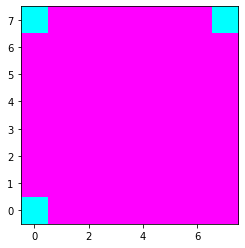

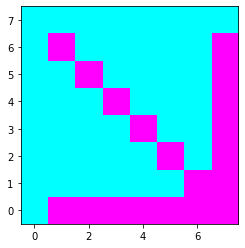

In [9]:
test=np.array([
    [0,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1],
    [0,1,1,1,1,1,1,0]
])
res=corner_state(test)

plt.imshow(test,origin='lower', vmax=1, vmin=0,cmap="cool")
plt.show()
plt.imshow(res,origin='lower', vmax=1, vmin=0,cmap="cool")
plt.show()

とりあえず読み込んで、後に使う分(回転させる奴)のメモリ分を確保しておく

In [10]:
state_list=np.zeros([len(data),8,8])
action_list=np.zeros([len(data)])
for index,line in enumerate(data):
    if "B" in line:
        state,action=transform(line,0)
    else:
        state,action=transform(line,1)
    state_list[index]=state
    action_list[index]=action
state_list=np.resize(state_list,(len(state_list)*4,8,8))
action_list=np.resize(action_list,len(action_list)*4)
print(state_list.shape,action_list.shape)

(594872, 8, 8) (594872,)


回して新しい状態を作る

In [11]:
original_len=148718

for index in range(original_len):
    now_state=state_list[index]
    now_action=action_list[index]
    for k in range(3):
        now_state=np.rot90(now_state).copy()
        now_action=new_action(now_action)
        state_list[index+original_len*(k+1)]=now_state
        action_list[index+original_len*(k+1)]=now_action
print(action_list.shape,state_list.shape)

(594872,) (594872, 8, 8)


盤面を白と黒のものに分ける

In [12]:
state_list_1=np.where(state_list==1,1,0)
state_list_2=np.where(state_list==2,1,0)

絶対に消えないマスを定義

In [13]:
corner_list_1=np.zeros([len(state_list_1),8,8])
corner_list_2=np.zeros([len(state_list_2),8,8])
for index,lists in enumerate(state_list_1):
    corner_list_1[index]=corner_state(lists)
for index,lists in enumerate(state_list_2):
    corner_list_2[index]=corner_state(lists)

どこにコマを置けるかの状態を定義する関数

In [14]:
def possible_state(old_state):
    dx=[1,1,1,0,-1,-1,-1,0]
    dy=[-1,0,1,1,1,0,-1,-1]
    possible_1=np.zeros([8,8])
    possible_2=np.zeros([8,8])
    possible_hand_1=np.zeros([8,8])
    possible_hand_2=np.zeros([8,8])
    for h in range(8):
        for w in range(8):
            num=1
            if(old_state[h][w]!=num):
                continue
            for lx,ly in zip(dx,dy):
                nowh=h+lx
                noww=w+ly
                flag=False
                possible_lists=[]
                while(True):
                    if((nowh<0)|(nowh>=8)|(noww<0)|(noww>=8)):
                        break
                    if(old_state[nowh][noww]==num):
                        break
                    elif(old_state[nowh][noww]==3-num):
                        possible_lists.append(nowh*8+noww)
                    else:
                        if(len(possible_lists)>=1):
                            possible_hand_1[nowh][noww]=1
                        flag=True
                        break
                    nowh+=lx
                    noww+=ly
                if(flag):
                    for possible in possible_lists:
                        possible_1[int(possible//8)][int(possible%8)]=1
        
    for h in range(8):
        for w in range(8):
            num=2
            if(old_state[h][w]!=num):
                continue
            for lx,ly in zip(dx,dy):
                nowh=h+lx
                noww=w+ly
                flag=False
                possible_lists=[]
                while(True):
                    if((nowh<0)|(nowh>=8)|(noww<0)|(noww>=8)):
                        break
                    if(old_state[nowh][noww]==num):
                        break
                    elif(old_state[nowh][noww]==3-num):
                        possible_lists.append(nowh*8+noww)
                    else:
                        if(len(possible_lists)>=1):
                            possible_hand_2[nowh][noww]=1
                        flag=True
                        break
                    nowh+=lx
                    noww+=ly
                if(flag):
                    for possible in possible_lists:
                        possible_2[int(possible//8)][int(possible%8)]=1
    return possible_1,possible_2,possible_hand_1,possible_hand_2

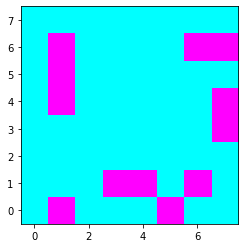

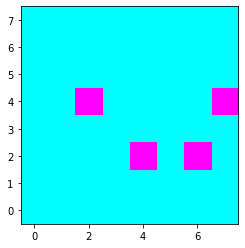

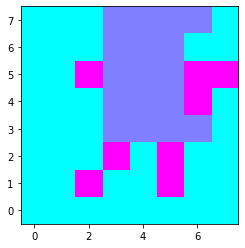

In [15]:
test=np.array([
    [0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,1,0,0,0,0],
    [0,0,0,1,2,0,0,0],
    [0,0,0,2,1,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0],
])

test=state_list[102]
p_1,p_2,h_1,h_2=possible_state(test)

plt.imshow(h_1,origin='lower', vmax=1, vmin=0,cmap="cool")
plt.show()
plt.imshow(h_2,origin='lower', vmax=1, vmin=0,cmap="cool")
plt.show()
plt.imshow(test,origin='lower', vmax=2, vmin=0,cmap="cool")
plt.show()

In [16]:
possible_hand_1=np.zeros([len(state_list),8,8])
possible_hand_2=np.zeros([len(state_list),8,8])
for index,lists in enumerate(state_list):
    p_1,p_2,h_1,h_2=possible_state(lists)
    possible_hand_1[index]=h_1
    possible_hand_2[index]=h_2

端っこだけを定義する

In [17]:
corner_only=np.zeros([1,8,8])
corner_only[0][0][0]=1
corner_only[0][7][0]=1
corner_only[0][0][7]=1
corner_only[0][7][7]=1
corner_only=np.resize(corner_only,(len(state_list_1),8,8))
corner_only.shape

(594872, 8, 8)

## 学習データ
以下のような学習データを準備した
- 白駒の盤面
- 黒駒の盤面
- 絶対取られない白駒の盤面
- 絶対取られない黒駒の盤面
- 白駒を置くことのできるのできる盤面
- 黒駒を置くことのできるのできる盤面
- 端っこ4つが1の盤面
以上7チャンネル

次元は(594872, 7, 8, 8)4次元テンソル

教師データは0~63

次元は(594872)

In [18]:
train=np.array([state_list_1,state_list_2,corner_list_1,corner_list_2,possible_hand_1,possible_hand_2,corner_only])
train=train.transpose(1,0,2,3)
print(train.shape)
num=10
display(train[num],action_list[num])

(594872, 7, 8, 8)


array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

12.0

訓練データとテストデータを8:2に分ける

In [19]:
import random
index = random.sample(range(len(train)),int(len(train)*0.8))
index_bool = np.zeros(len(train), dtype=bool)
index_bool[index] = True
train_data=train[index_bool]
test_data=train[~index_bool]
train_label=action_list[index_bool]
test_label=action_list[~index_bool]
print(int(len(train)*0.8),len(index))
display(index_bool)
print(train.shape,train_data.shape,train_label.shape,test_data.shape,test_label.shape)

475897 475897


array([ True,  True,  True, ...,  True,  True,  True])

(594872, 7, 8, 8) (475897, 7, 8, 8) (475897,) (118975, 7, 8, 8) (118975,)


## モデル構築
初手1次元へ平滑化

そのあとはお肌にいいと聞いたBatch Normalizationと密結合された層を交互に適当にかます(ここら辺はなんも分からん)




In [20]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7,8,8)),
    keras.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001),
    keras.layers.Dense(64, activation='softmax')
])

最適化にAdamを、損失関数に交差エントロピー誤差の亜種みたいなやつを使う

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

学習、のんのんびより約二話分かかる

In [22]:
model.fit(train_data, train_label, epochs=20)

Train on 475897 samples
Epoch 1/20
475897/475897 [==============================] - 47s 98us/sample - loss: 2.8372 - accuracy: 0.1692
Epoch 2/20
475897/475897 [==============================] - 46s 97us/sample - loss: 2.5748 - accuracy: 0.2060
Epoch 3/20
475897/475897 [==============================] - 45s 94us/sample - loss: 2.5059 - accuracy: 0.2205
Epoch 4/20
475897/475897 [==============================] - 45s 95us/sample - loss: 2.4614 - accuracy: 0.2315
Epoch 5/20
475897/475897 [==============================] - 45s 94us/sample - loss: 2.4326 - accuracy: 0.2385
Epoch 6/20
475897/475897 [==============================] - 45s 94us/sample - loss: 2.4084 - accuracy: 0.2447
Epoch 7/20
475897/475897 [==============================] - 45s 95us/sample - loss: 2.3884 - accuracy: 0.2494
Epoch 8/20
475897/475897 [==============================] - 44s 93us/sample - loss: 2.3728 - accuracy: 0.2539
Epoch 9/20
475897/475897 [==============================] - 45s 94us/sample - loss: 2.3586 - acc

NameError: name 'slack_notify' is not defined

評価、予想以上に高精度でビビった

In [23]:
test_loss, test_acc = model.evaluate(test_data, test_label, verbose=2)

118975/118975 - 5s - loss: 2.2719 - accuracy: 0.2798


In [24]:
predictions=model.predict(test_data)

In [25]:
display(test_data[10],predictions[10])

array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

array([9.1408219e-06, 6.6013883e-05, 1.0528561e-05, 5.8046970e-07,
       1.2481422e-05, 3.5323130e-05, 5.2555442e-06, 1.6251630e-04,
       3.6467838e-05, 2.2419742e-06, 5.4009218e-04, 4.0365257e-03,
       5.4792919e-05, 1.8896366e-05, 1.4819626e-05, 2.6343765e-05,
       7.0332121e-06, 1.3395257e-03, 3.6078534e-05, 2.6302558e-01,
       1.1195152e-02, 8.0593703e-03, 2.2366652e-04, 1.9295083e-04,
       1.6764176e-07, 1.8375057e-01, 1.8161455e-03, 5.0534937e-10,
       5.2951066e-10, 6.1164699e-03, 1.2825543e-04, 5.9430313e-05,
       4.1351127e-06, 6.7442801e-05, 3.9222105e-03, 5.2372118e-10,
       5.3953125e-10, 3.7021569e-03, 1.3982439e-01, 5.0925632e-07,
       6.2549283e-05, 5.3965818e-05, 1.4163337e-02, 3.2597706e-03,
       3.4493884e-01, 1.7827240e-05, 2.5340896e-03, 6.4285909e-05,
       1.3847175e-05, 1.5119469e-05, 2.9005347e-05, 3.8107581e-05,
       4.9784509e-03, 7.5694494e-04, 4.9119544e-06, 4.6168036e-05,
       1.4027234e-04, 1.8466360e-05, 1.6379343e-04, 7.9584897e

最後に可視化

0.23848511
0.23759012
0.13690706
0.1128242
0.040807553


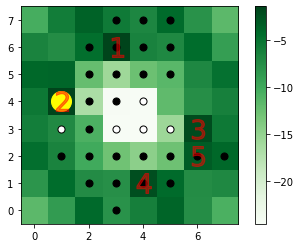

0.30124128
0.28151396
0.04852243
0.043687396
0.040036757


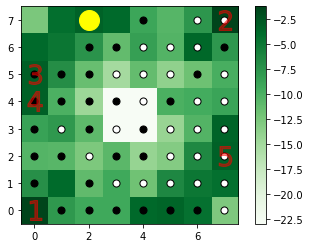

0.101785205
0.10132471
0.08136541
0.08089001
0.07711938


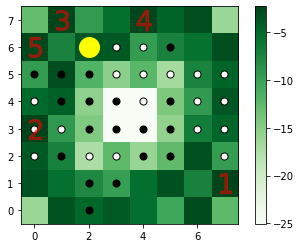

0.24532989
0.22484285
0.17691635
0.13042083
0.114223935


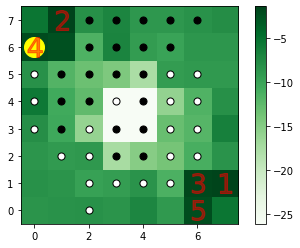

0.17391571
0.14680873
0.111534506
0.060379468
0.055362023


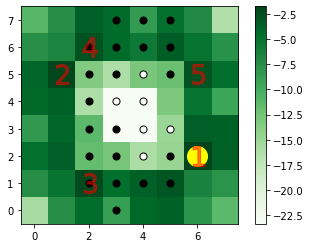

0.10906944
0.10091113
0.07766462
0.074614786
0.061015382


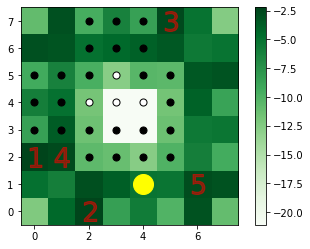

0.61142623
0.2204686
0.10387655
0.05731211
0.0008472584


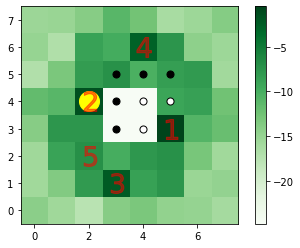

0.6397313
0.3528452
0.0027259793
0.0020872613
0.0003453157


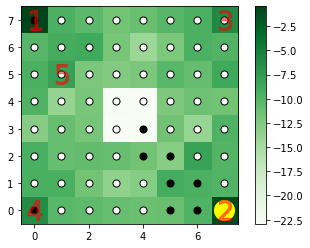

0.14535479
0.14387429
0.112897664
0.0815988
0.0702767


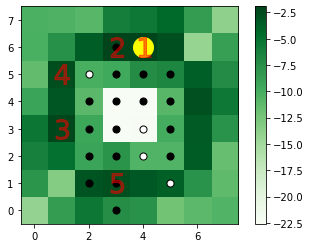

0.55621916
0.22975056
0.059824318
0.02934318
0.026741486


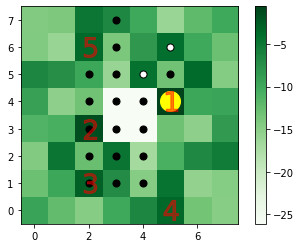

0.09045018
0.08496741
0.08307352
0.066692255
0.06251231


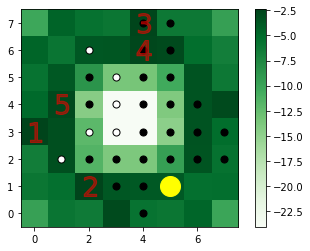

0.11930293
0.09408277
0.07891583
0.07829447
0.077777326


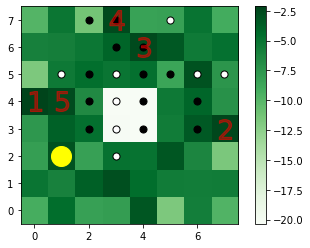

0.10699597
0.10375376
0.100497544
0.08631761
0.08339176


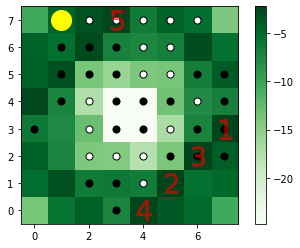

0.2372933
0.18164496
0.14664619
0.10076127
0.08444024


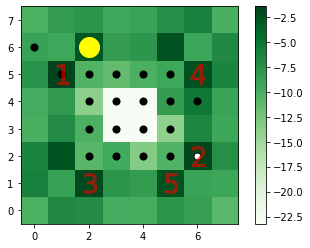

0.2804573
0.18819076
0.12962593
0.10677116
0.106593326


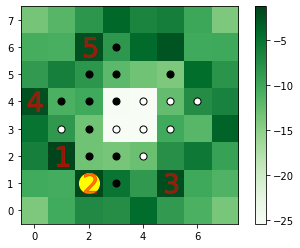

0.3218053
0.2889118
0.07284303
0.06621252
0.06603186


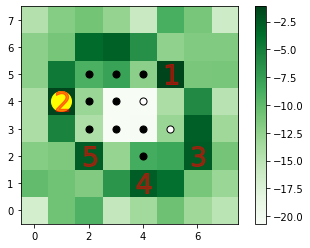

0.35986763
0.34095296
0.052633002
0.052039262
0.04526587


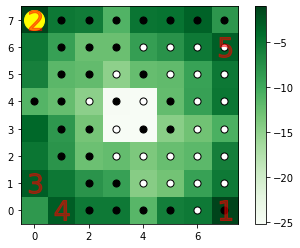

0.12512392
0.100812085
0.08036335
0.07378206
0.067167275


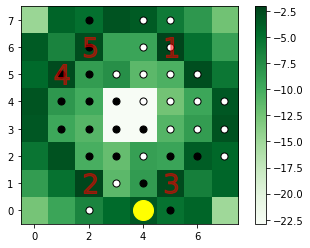

0.37309286
0.10980655
0.08736783
0.07810207
0.05967283


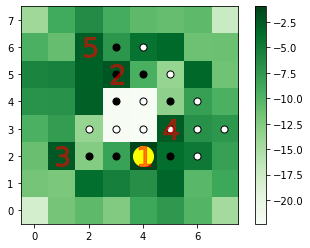

0.16415153
0.108053684
0.09864786
0.0827906
0.06632971


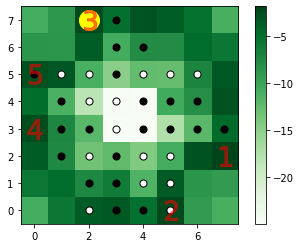

In [29]:
for i in range(20):
    num=i*17
    prediction_data = np.array([predictions[num][j] for j in range(64)]).reshape(8,8)
    plt.imshow(np.log(prediction_data),origin='lower', vmax=np.log(prediction_data).max(), vmin=np.log(prediction_data).min(),cmap="Greens")
    plt.colorbar(cmap="Greens")
    for j in range(8):
        for k in range(8):
            if(test_data[num][0][k][j]==1):
                plt.scatter(j,k,marker="o",c="black",s=50)
            if(test_data[num][1][k][j]==1):
                plt.scatter(j,k,marker="o",c="white",s=50,edgecolors="black")
    plt.scatter(test_label[num]%8,test_label[num]//8,marker="o",c="yellow",s=400)
    test=np.array([5,4,3,2,1])
    order_vec=np.argsort(predictions[num])[::-1]
   # print(test_label[num])
    for order in range(5):
        s="$"+str(order+1)+"$"
        print(predictions[num][order_vec[order]])
        plt.scatter(order_vec[order]%8,order_vec[order]//8,marker=s,c="red",s=400,alpha=0.5)
    plt.show()